In [3]:
import os
import numpy as np
from skimage import io, img_as_ubyte
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from skimage.morphology import area_opening


In [8]:
# filenames are structured with '_w1', '_w2', '_w3' to indicate channels.
input_directory = '/Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/TimePoint_1'
rgb_output_directory = '/Users/elizabeth 1/Library/CloudStorage/Box-Box/Wu Lab/Project - 2024/Functional screening/240411 test in 6-well/Moe Effciency_Plate_1252/color composite_Elizabeth'
output_directory_red = os.path.join(rgb_output_directory, 'red_only')
output_directory_green = os.path.join(rgb_output_directory, 'green_only')

In [11]:
# Ensure output directories exist
os.makedirs(output_directory_rgb, exist_ok=True)
os.makedirs(output_directory_red, exist_ok=True)
os.makedirs(output_directory_green, exist_ok=True)

In [12]:

def load_image(filename):
    return io.imread(os.path.join(input_directory, filename), as_gray=True)

def process_channel(image, sigma, percentile_normalize=True, lower_percentile=2, upper_percentile=98):
    background = gaussian(image, sigma=sigma)
    image_subtracted = image - background
    image_subtracted = np.clip(image_subtracted, 0, None)

    if percentile_normalize:
        low, high = np.percentile(image_subtracted, [lower_percentile, upper_percentile])
        image_normalized = (image_subtracted - low) / (high - low) if high > low else image_subtracted
        image_normalized = np.clip(image_normalized, 0, 1)
        return image_normalized
    else:
        if np.max(image_subtracted) > 0:
            return image_subtracted / np.max(image_subtracted)
        return image_subtracted

def save_image(image, filename, directory):
    io.imsave(os.path.join(directory, filename), img_as_ubyte(image))

In [9]:
# Gather all filenames and filter out thumbnails
filenames = [f for f in sorted(os.listdir(input_directory)) if 'Thumb' not in f]

# Pair up red and green channel images
paired_files = {}
for filename in filenames:
    if '_w1' in filename:
        base_name = filename.split('_w1')[0]
        paired_files.setdefault(base_name, {})[0] = filename
    elif '_w2' in filename:
        base_name = filename.split('_w2')[0]
        paired_files.setdefault(base_name, {})[1] = filename

# All Channels Percentile Normalized

In [10]:
paired_files['Moe Effciency_A02_s1'][0]

'Moe Effciency_A02_s1_w1.TIF'

In [27]:
def save_colored_channel_image(image, channel_index, filename, directory):
    # Create a full black image with the same shape as the original RGB
    colored_image = np.zeros((image.shape[0], image.shape[1], 3))
    # Insert the processed channel into the correct slot
    colored_image[:, :, channel_index] = image
    # Convert to 8-bit and save
    io.imsave(os.path.join(directory, filename), img_as_ubyte(colored_image))

i = 1
# In the main loop, after processing each channel:
for base_name, files in paired_files.items():
    if 0 in files and 1 in files:
        img_red = load_image(files[0])
        img_green = load_image(files[1])

        # Process channels with specified normalization techniques
        img_red = process_channel(img_red, sigma=25, percentile_normalize=True)
        img_green = process_channel(img_green, sigma=50, percentile_normalize=True)

        # Save processed images as colored images
        save_colored_channel_image(img_red, 0, f"{base_name}_red.tif", output_directory_red)
        save_colored_channel_image(img_green, 1, f"{base_name}_green.tif", output_directory_green)

        # Also create and save the RGB image
        img_blue = np.zeros_like(img_red)
        rgb_image = np.stack([img_red, img_green, img_blue], axis=-1)
        save_image(rgb_image, f"{base_name}_rgb.tif", output_directory_rgb)
        print(i)
        i += 1


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [13]:
i = 1
# In the main loop, after processing each channel:
img_red = load_image(paired_files['Moe Effciency_A02_s1'][0])
img_green = load_image(paired_files['Moe Effciency_A02_s1'][1])

# Process channels with specified normalization techniques
img_red_processed = process_channel(img_red, sigma=100)
img_green_processed = process_channel(img_green, sigma=100)


1


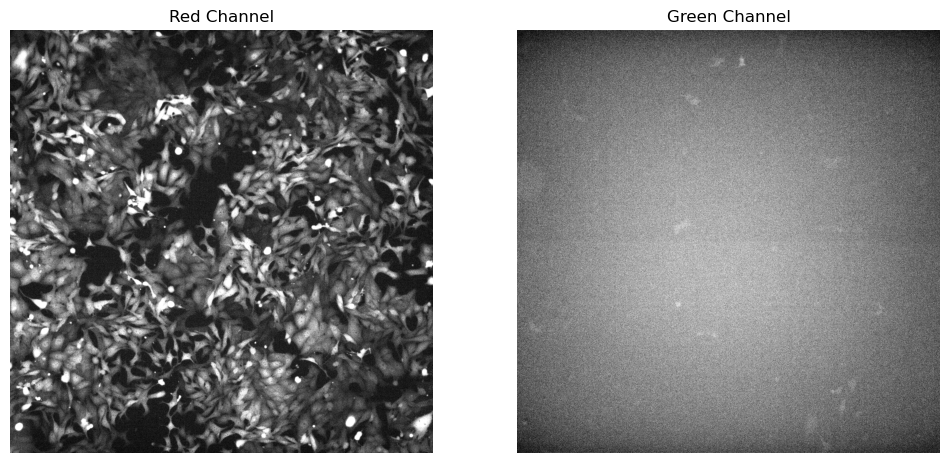

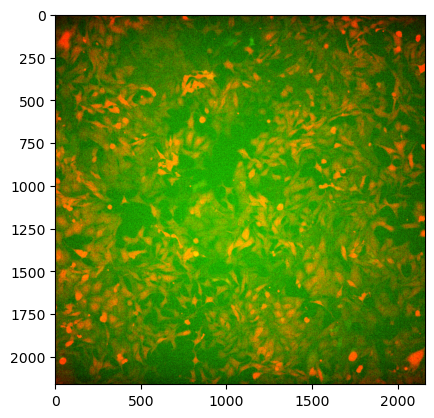

In [50]:

# Save processed images as colored images
# save_colored_channel_image(img_red, 0, f"{base_name}_red.tif", output_directory_red)
# save_colored_channel_image(img_green, 1, f"{base_name}_green.tif", output_directory_green)

# Also create and save the RGB image
img_blue = np.zeros_like(img_red)
rgb_image = np.stack([img_red_processed, img_green_processed, img_blue], axis=-1)

# save_image(rgb_image, f"{base_name}_rgb.tif", output_directory_rgb)
print(i)
i += 1

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_red_processed, cmap='gray')
plt.title(f'Red Channel')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_green_processed, cmap='gray')
plt.title(f'Green Channel')
plt.axis('off')


plt.figure()
plt.imshow(rgb_image)


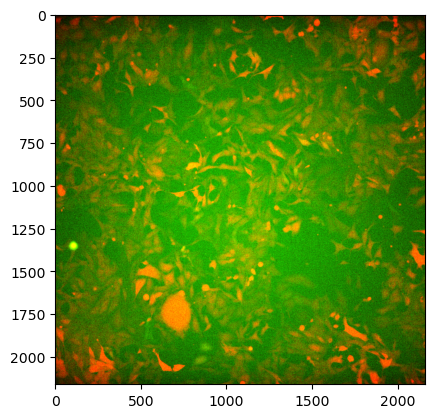

In [19]:
plt.imshow(rgb_image)

# Low Pass Fourier Transform for Flashback Channel

1. **Background Subtraction:** Estimate and subtract the background to normalize the image illumination and remove any large-area artifacts.
2. **Percentile Normalization:** Apply percentile normalization to enhance the contrast of the resulting image.
3. **Fourier Transform:** Perform the Fourier transform on the preprocessed image to move into the frequency domain.
4. **Frequency Domain Filtering:** Apply low-pass frequency domain filter to remove noise.
5. **Inverse Fourier Transform:** Transform back to the spatial domain & see the results.

Text(0.5, 1.0, 'Background-Subtracted & Normalized Green Channel (w/ noise)')

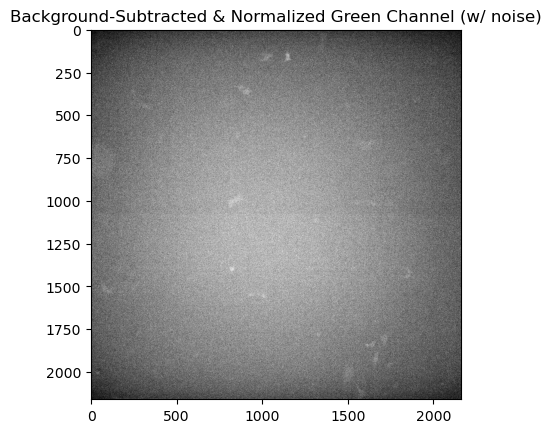

In [37]:
plt.imshow(img_green_processed, cmap='gray')
plt.title('Background-Subtracted & Normalized Green Channel (w/ noise)')

In [14]:
# Import Fourier transform functions
from scipy.fft import fft2, ifft2, fftshift, ifftshift

In [15]:
def fourier_lowpass(image, cutoff_frequency):
    # Apply Fourier transform to the image
    f_transform = fft2(image)
    f_transform_shifted = fftshift(f_transform)

    # Create a mask with high value (1) at low frequency and low value (0) at high frequency
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-cutoff_frequency:crow+cutoff_frequency, ccol-cutoff_frequency:ccol+cutoff_frequency] = 1

    # Apply mask to the shifted Fourier transformed image
    f_transform_shifted_filtered = f_transform_shifted * mask

    # Inverse shift and inverse Fourier transform to get the filtered image
    f_transform_filtered = ifftshift(f_transform_shifted_filtered)
    filtered_image = ifft2(f_transform_filtered)
    filtered_image = np.abs(filtered_image)

    return filtered_image


## (Fourier) Frequency Histogram
-  If the noise has a regular pattern, it might show up as **spikes in the high-frequency end of the spectrum**.
-  If there's a clear **gap** between the frequencies of noise and the frequencies of the signal, set a cutoff that tries to keep the signal and remove the noise.
- After applying the filter, **compare** the before and after histograms to see the effectiveness of  noise reduction.

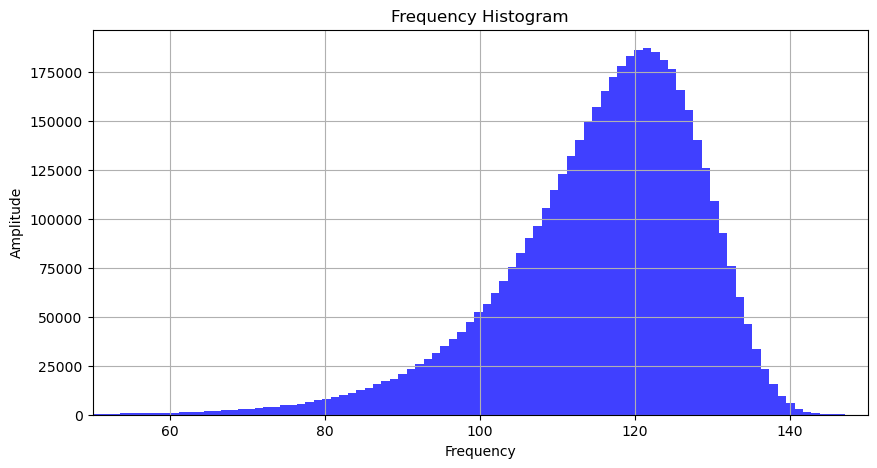

In [32]:
def plot_frequency_histogram(image):
    # Apply Fourier transform to the image
    f_transform = fft2(image)
    f_transform_shifted = fftshift(f_transform)

    # Calculate the magnitude spectrum of the Fourier transform
    magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted))

    # Plot the magnitude spectrum as a histogram
    plt.figure(figsize=(10, 5))
    plt.hist(magnitude_spectrum.ravel(), bins=300, color='blue', alpha=0.75)
    plt.title('Frequency Histogram')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.xlim(50,150)
    plt.grid(True)
    plt.show()

    return magnitude_spectrum

magnitude_spectrum = plot_frequency_histogram(img_green_processed)


## Apply Fourrier Transform
Trial and Error:
 - If after applying the cutoff the image retains **too much noise**, you may need to **lower** the cutoff frequency
  - If the image becomes **too blurry** or loses significant detail, you might need to **increase the cutoff frequency**.

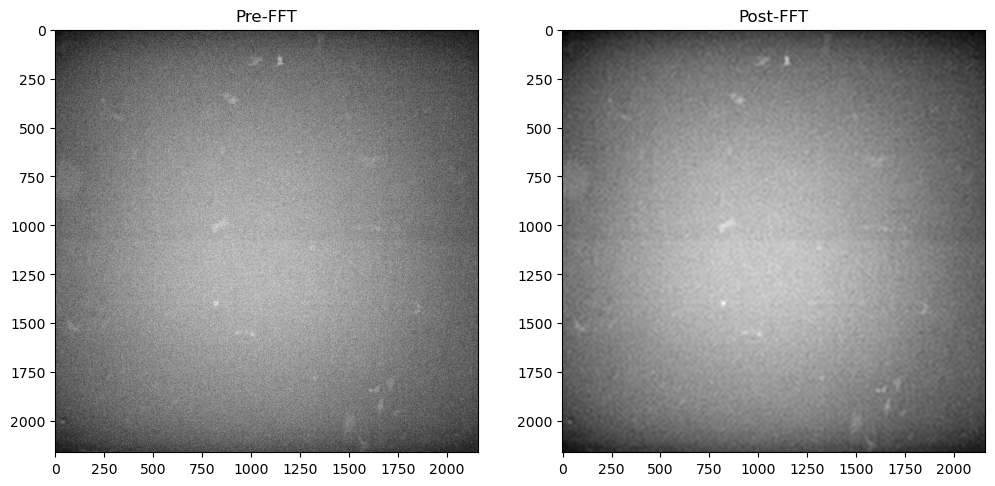

In [16]:
# Adjust the 'cutoff_frequency' parameter 
cutoff_frequency = 80 

filtered_image = fourier_lowpass(img_green_processed, cutoff_frequency)

# Display the original and filtered images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Pre-FFT')
plt.imshow(img_green_processed, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Post-FFT')
plt.imshow(filtered_image, cmap='gray')

plt.show()

# Adaptive Thresholding

In [17]:
from skimage import io, img_as_ubyte, filters

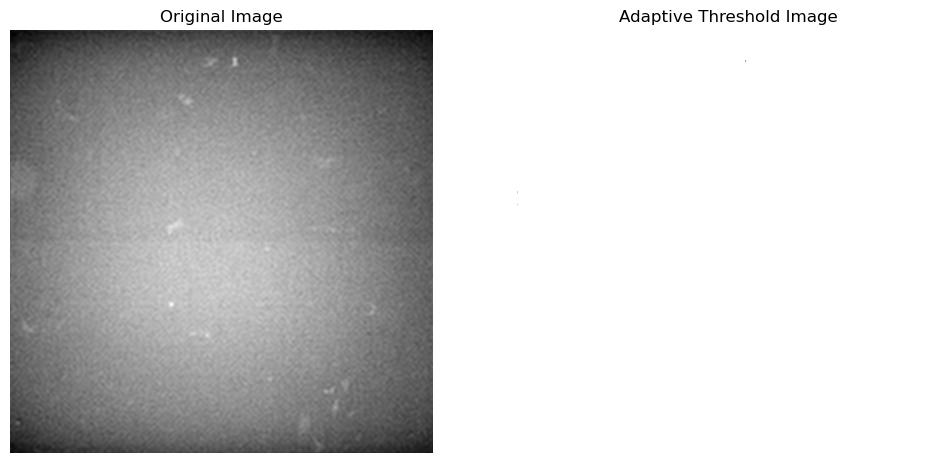

In [18]:

# Convert to 8-bit for further processing
filtered_image = img_as_ubyte(filtered_image)

# Apply adaptive thresholding
block_size = 35  # This is the size of the neighbourhood area
adaptive_threshold = filters.threshold_local(filtered_image, block_size, offset=10)
binary_image = filtered_image > adaptive_threshold

# Display the original and thresholded images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks

plt.subplot(1, 2, 2)
plt.title('Adaptive Threshold Image')
plt.imshow(binary_image, cmap='gray')
plt.axis('off')

plt.show()


# Area Opening

In [46]:
# Area op
# Convert the image to 8-bit if it's not already
image_ubyte = img_as_ubyte(img_green_processed)

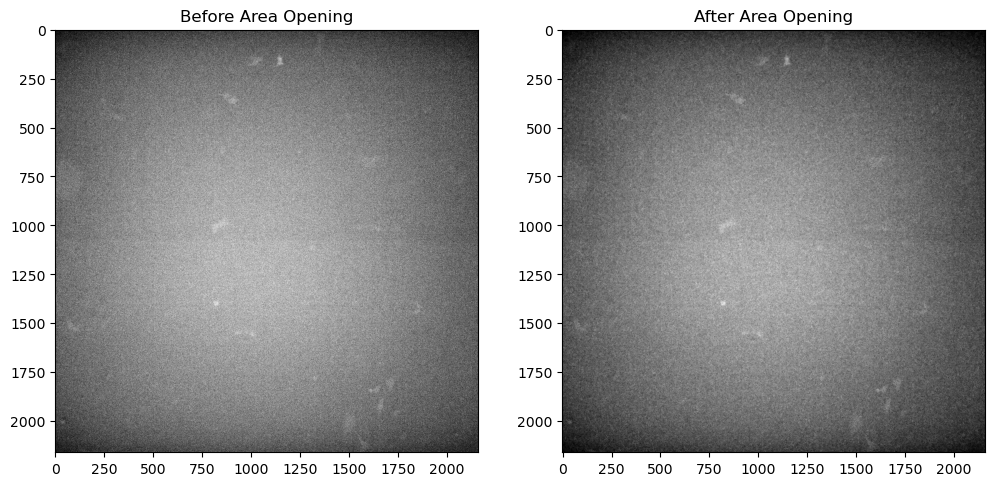

In [52]:

# Apply area opening operation
# You need to define 'area_threshold' based on the size of the noise and cells
area_threshold = 30  # for example, to remove areas smaller than 100 pixels
opened_image = area_opening(image_ubyte, area_threshold=area_threshold)

# View the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Before Area Opening')
plt.imshow(image_ubyte, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('After Area Opening with strel 30')
plt.imshow(opened_image, cmap='gray')
plt.show()


In [ ]:

# Apply area opening operation
# You need to define 'area_threshold' based on the size of the noise and cells
area_threshold = 50  # for example, to remove areas smaller than 100 pixels
opened_image = area_opening(image_ubyte, area_threshold=area_threshold)

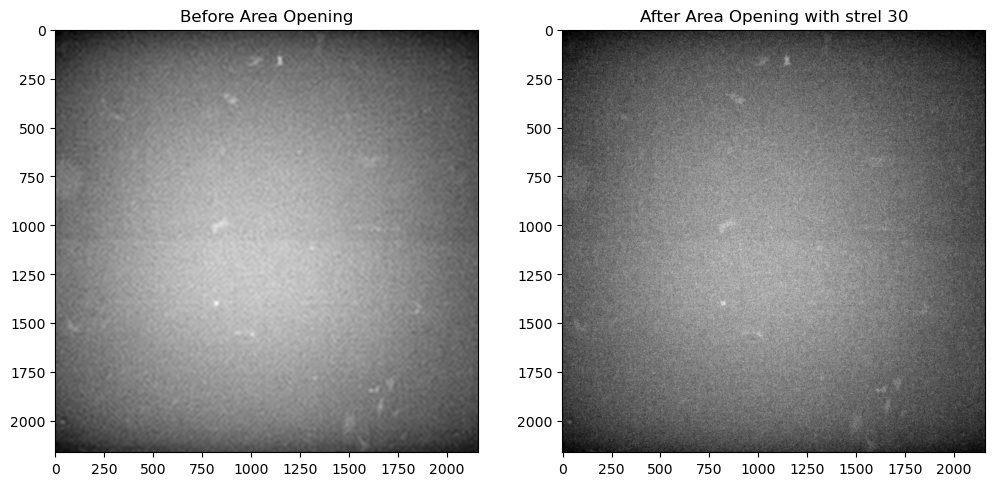

In [72]:

# View the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Before Area Opening')
plt.imshow(image_ubyte, cmap='gray')
plt.subplot(1, 2, 2)
plt.title(f'After Area Opening with strel {area_threshold}')
plt.imshow(opened_image, cmap='gray')
plt.show()


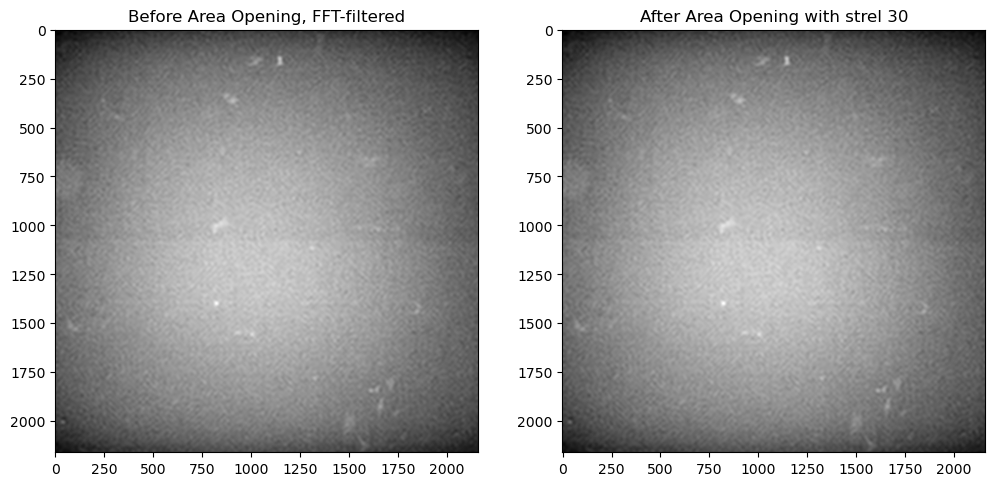

In [55]:
# Convert the image to 8-bit if it's not already
image_ubyte = img_as_ubyte(filtered_image)
# Apply area opening operation
# You need to define 'area_threshold' based on the size of the noise and cells
area_threshold = 30  # for example, to remove areas smaller than 100 pixels
opened_image_fft = area_opening(image_ubyte, area_threshold=area_threshold)

# View the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Before Area Opening, FFT-filtered')
plt.imshow(image_ubyte, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('After Area Opening with strel 30')
plt.imshow(opened_image_fft, cmap='gray')
plt.show()


# Rolling Ball Algorithm

In [22]:
from skimage import io, filters, restoration, img_as_ubyte

print(dir(filters))


['LPIFilter2D', 'apply_hysteresis_threshold', 'butterworth', 'correlate_sparse', 'difference_of_gaussians', 'farid', 'farid_h', 'farid_v', 'frangi', 'gabor', 'gabor_kernel', 'gaussian', 'hessian', 'inverse', 'laplace', 'median', 'meijering', 'prewitt', 'prewitt_h', 'prewitt_v', 'rank', 'rank_order', 'roberts', 'roberts_neg_diag', 'roberts_pos_diag', 'sato', 'scharr', 'scharr_h', 'scharr_v', 'sobel', 'sobel_h', 'sobel_v', 'threshold_isodata', 'threshold_li', 'threshold_local', 'threshold_mean', 'threshold_minimum', 'threshold_multiotsu', 'threshold_niblack', 'threshold_otsu', 'threshold_sauvola', 'threshold_triangle', 'threshold_yen', 'try_all_threshold', 'unsharp_mask', 'wiener', 'window']


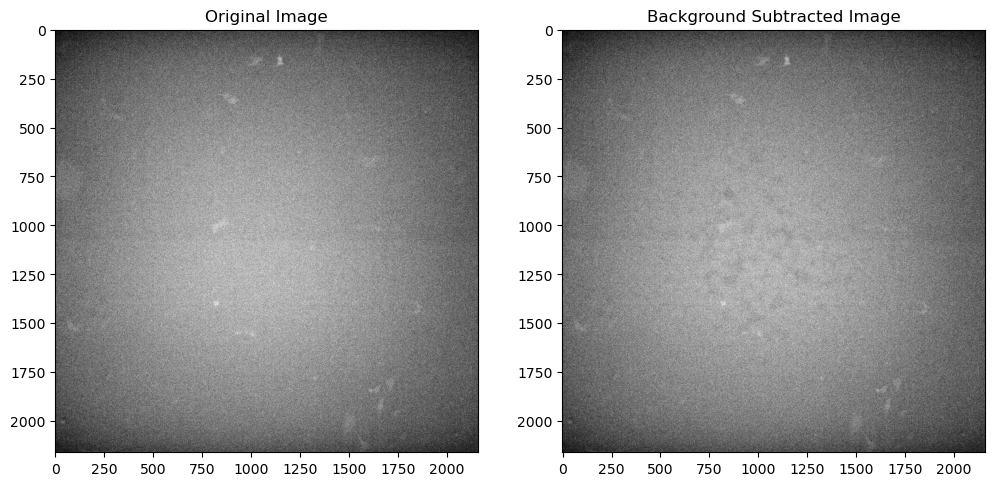

In [25]:
image_ubyte = img_as_ubyte(img_green_processed)

# determine the appropriate radius for your image
ball_radius = 50  # example radius

# Use rolling ball algorithm to estimate the background
background = restoration.rolling_ball(image_ubyte, radius=ball_radius)

# Subtract the background from the original image
image_background_subtracted = image_ubyte - background

# Display the original and background-subtracted images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_ubyte, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Background Subtracted Image')
plt.imshow(image_background_subtracted, cmap='gray')
plt.show()


In [26]:
img_green_processed = img_as_ubyte(img_green_processed)

dtype('float64')